In [14]:
import pandas as pd
import os
from collections import defaultdict
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import cv2
import numpy as np
from tqdm import tqdm


Image.MAX_IMAGE_PIXELS = None #Throws error if size of images exceeds this number

In [2]:
class CustomDataset(Dataset):
    def __init__(self, csv_file, root_dir, num_classes, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            num_classes (int): Total number of classes.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.labels_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.num_classes = num_classes
        self.transform = transform

    def __len__(self):
        return len(self.labels_frame.index)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, str(self.labels_frame.iloc[idx, 0])) + '.jpg'
        image = cv2.imread(img_name)
        
        #image = Image.open(img_name)
        label = self.labels_frame.iloc[idx, 1]

        # Convert label to one-hot encoding
        one_hot = label_dict[label]

        if self.transform:
            image = self.transform(image)

        return image, one_hot

In [3]:
#Creates dictionary mapping labels(string) to vector(one-hot encoding)
all_labels = list(np.load('materials/UBC-OCEAN_CS640/all_labels.npy'))
num_classes = len(all_labels)
label_dict = defaultdict(lambda: torch.zeros(num_classes))
for i, label in enumerate(all_labels):
    label_dict[label][i] = 1

In [4]:
# Define initial transform as resize
transform = transforms.Compose([transforms.ToTensor(), transforms.Resize((224, 224))])
# Create the dataset
dataset = CustomDataset(csv_file='materials/UBC-OCEAN_CS640/train.csv', root_dir='materials/UBC-OCEAN_CS640/train_images_compressed_80/', num_classes=num_classes, transform=transform)

# Create a DataLoader
dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

#Size of the reshaped first image in the data set
#(RGB * width * height)
print(f'Number of training images: {dataset.__len__()}')
print(f'Type of first pairing: {type(dataset.__getitem__(0))}')
print(f'Items in tuple: {len(dataset.__getitem__(0))}')
print(f'Size of Image: {dataset.__getitem__(0)[0].size()}')
print(f'First Image (Raw): {dataset.__getitem__(0)[0]}')
print(f'One hot output of first image: {dataset.__getitem__(0)[1]}')


Number of training images: 430


c:\Users\TaiSh\.conda\envs\conda311\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Type of first pairing: <class 'tuple'>
Items in tuple: 2
Size of Image: torch.Size([3, 224, 224])
First Image (Raw): tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])
One hot output of first image: tensor([0., 0., 0., 1., 0.])


In [5]:
# Function to calculate mean and std
def get_mean_and_std(dataloader):
    channels_sum, channels_squared_sum, num_batches = 0, 0, 0

    for data, _ in tqdm(dataloader):
        channels_sum += torch.mean(data, dim=[0, 2, 3])
        channels_squared_sum += torch.mean(data**2, dim=[0, 2, 3])
        num_batches += 1

    mean = channels_sum / num_batches
    std = (channels_squared_sum / num_batches - mean**2)**0.5

    return mean, std

#Calculate mean and std of RGB values
mean, std = get_mean_and_std(dataloader)
mean, std = 
print(f"Mean: {mean}")
print(f"Std: {std}")

100%|██████████| 54/54 [22:06<00:00, 24.56s/it]

Mean: tensor([0.4887, 0.4266, 0.4855])
Std: tensor([0.4212, 0.3790, 0.4169])


In [9]:
# Transform = resize images and normalize the RGB values
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224)),

    transforms.Normalize(mean=mean, std=std)
])

batch_size = 8

# Create the dataset
train_dataset = CustomDataset(csv_file='materials/UBC-OCEAN_CS640/train.csv', root_dir='materials/UBC-OCEAN_CS640/train_images_compressed_80/', num_classes=num_classes, transform=transform)
test_dataset = CustomDataset(csv_file='materials/UBC-OCEAN_CS640/test.csv', root_dir='materials/UBC-OCEAN_CS640/test_images_compressed_80/', num_classes=num_classes, transform=transform)

# Create a DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

# Now you can use this dataloader in your training loop

In [10]:
#Size of the reshaped first image in the data set
#(RGB * width * height)
print(f'Numer of training examples: {train_dataset.__len__()}')
print(f'Numer of testing examples: {test_dataset.__len__()}')
print(f'Type of pairing: {type(train_dataset.__getitem__(0))}')
print(f'Number of inputs + outputs: {len(train_dataset.__getitem__(0))}')
print(f'Size of input: {train_dataset.__getitem__(0)[0].size()}')
print(f'First input(normalized): {train_dataset.__getitem__(0)[0]}')
print(f'First output(one-hot encoding): {train_dataset.__getitem__(0)[1]}')

Numer of training examples: 430
Numer of testing examples: 108


c:\Users\TaiSh\.conda\envs\conda311\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Type of pairing: <class 'tuple'>
Number of inputs + outputs: 2
Size of input: torch.Size([3, 224, 224])
First input(normalized): tensor([[[-1.1601, -1.1601, -1.1601,  ..., -1.1601, -1.1601, -1.1601],
         [-1.1601, -1.1601, -1.1601,  ..., -1.1601, -1.1601, -1.1601],
         [-1.1601, -1.1601, -1.1601,  ..., -1.1601, -1.1601, -1.1601],
         ...,
         [-1.1601, -1.1601, -1.1601,  ..., -1.1601, -1.1601, -1.1601],
         [-1.1601, -1.1601, -1.1601,  ..., -1.1601, -1.1601, -1.1601],
         [-1.1601, -1.1601, -1.1601,  ..., -1.1601, -1.1601, -1.1601]],

        [[-1.1258, -1.1258, -1.1258,  ..., -1.1258, -1.1258, -1.1258],
         [-1.1258, -1.1258, -1.1258,  ..., -1.1258, -1.1258, -1.1258],
         [-1.1258, -1.1258, -1.1258,  ..., -1.1258, -1.1258, -1.1258],
         ...,
         [-1.1258, -1.1258, -1.1258,  ..., -1.1258, -1.1258, -1.1258],
         [-1.1258, -1.1258, -1.1258,  ..., -1.1258, -1.1258, -1.1258],
         [-1.1258, -1.1258, -1.1258,  ..., -1.1258, -1.1258,

In [11]:
# torch.cuda.is_available() checks and returns a Boolean True if a GPU is available, else it'll return False
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU is available


In [12]:
class CancerCNN_1(nn.Module):
    def __init__(self):
        super(CancerCNN_1, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        # Adjust the size of the fully connected layer
        self.fc1 = nn.Linear(128 * 28 * 28, 512)
        self.fc2 = nn.Linear(512, 5) # Adjust according to the number of classes
        self.pool = nn.MaxPool2d(2, 2)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        x = x.view(-1, 128 * 28 * 28) # Adjust this flattening based on the output size
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [13]:
# Step 4: Initialize the CNN Model
model_1 = CancerCNN_1().float()
print(model_1)

model_1 = model_1.to(device)

# Step 5: Define Loss Function and Optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model_1.parameters(), lr=0.0001)

CancerCNN_1(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=100352, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=5, bias=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
)


  0%|          | 0/14 [00:00<?, ?it/s]/projectnb/cs640grp/students/sglee21/.conda/envs/conda311/lib/python3.11/site-packages/PIL/Image.py:3182: DecompressionBombWarning: Image size (380720000 pixels) exceeds limit of 357913940 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/projectnb/cs640grp/students/sglee21/.conda/envs/conda311/lib/python3.11/site-packages/PIL/Image.py:3182: DecompressionBombWarning: Image size (367380000 pixels) exceeds limit of 357913940 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/projectnb/cs640grp/students/sglee21/.conda/envs/conda311/lib/python3.11/site-packages/PIL/Image.py:3182: DecompressionBombWarning: Image size (383220000 pixels) exceeds limit of 357913940 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/projectnb/cs640grp/students/sglee21/.conda/envs/conda311/lib/python3.11/site-packages/PIL/Image.py:3182: DecompressionBombWarning: Image size (379680000 pixels) exceeds limit of 357913940 pixels, cou

Epoch 1, Loss: 0.4690956175327301



 20%|██        | 2/10 [35:07<2:20:26, 1053.35s/it]

Epoch 2, Loss: 0.45967379212379456



 30%|███       | 3/10 [52:39<2:02:51, 1053.09s/it]

Epoch 3, Loss: 0.5050300359725952



 40%|████      | 4/10 [1:10:11<1:45:15, 1052.55s/it]

Epoch 4, Loss: 0.3707001805305481



 50%|█████     | 5/10 [1:27:43<1:27:41, 1052.28s/it]

Epoch 5, Loss: 0.409364253282547



 60%|██████    | 6/10 [1:45:16<1:10:10, 1052.64s/it]

Epoch 6, Loss: 0.269835889339447



 70%|███████   | 7/10 [2:02:48<52:37, 1052.37s/it]  

Epoch 7, Loss: 0.2883692681789398



 80%|████████  | 8/10 [2:20:21<35:04, 1052.43s/it]

Epoch 8, Loss: 0.10217292606830597



 90%|█████████ | 9/10 [2:37:53<17:32, 1052.41s/it]

Epoch 9, Loss: 0.1274905651807785



100%|██████████| 10/10 [2:55:24<00:00, 1052.49s/it]


Epoch 10, Loss: 0.008824728429317474


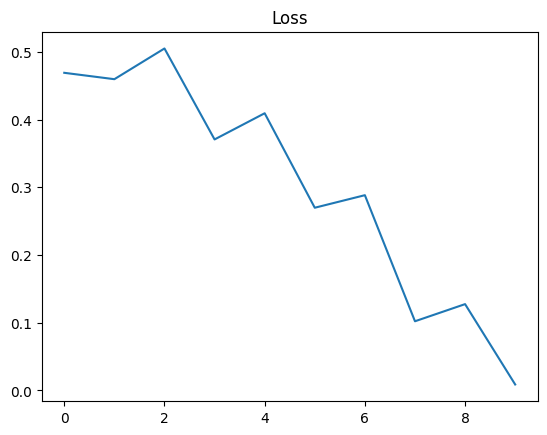

In [21]:
num_epochs = 10

losses = []


# Train the Model
try:
    model_1 = torch.load('Cancer_CNN_1.pt')
    img = mpimg.imread('loss_1.png')
    imgplot = plt.imshow(img)
    plt.show()

except:
    model_1.train()
    for epoch in tqdm(range(num_epochs)):  # Number of epochs
        for data, target in tqdm(dataloader):
            data = data.to(device)
            target = target.to(device)
            optimizer.zero_grad()
            output = model_1(data)
            loss = criterion(output, target.type_as(output)) # Ensuring target is same type as output
            loss.backward()
            optimizer.step()
        losses.append(loss.item())
        print(f'Epoch {epoch+1}, Loss: {loss.item()}')
    torch.save(model_1, 'Cancer_CNN_1.pt')
    
    fig = plt.figure()
    ax = plt.subplot(111)
    ax.plot(losses)
    plt.title('Loss')
    plt.show()
    fig.savefig('loss_1.png')
